In [1]:
from skimage import color, io, measure
from skimage.measure import profile_line
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import seaborn as sns
import pandas as pd
from sklearn import decomposition
import math
from skimage.filters import threshold_otsu
from skimage import color
from scipy.ndimage import correlate
from skimage.filters import median
from skimage.filters import gaussian
from skimage.filters import prewitt_h
from skimage.filters import prewitt_v
from skimage.filters import prewitt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.morphology import erosion, dilation, opening, closing
from skimage.morphology import disk
from skimage.morphology import binary_closing, binary_opening
from skimage.color import label2rgb
from scipy.stats import norm
from scipy.spatial import distance
from skimage.util import img_as_float, img_as_uint
from skimage.transform import rotate
from skimage.transform import EuclideanTransform
from skimage.transform import SimilarityTransform
from skimage.transform import swirl
from skimage.transform import matrix_transform
from skimage import segmentation
import glob
from PIL import Image
from sklearn.decomposition import PCA
from skimage.transform import warp
from scipy.ndimage import binary_dilation, binary_erosion
from skimage import io, img_as_ubyte, color
from exam_functions import *

# import SimpleITK as sitk
from IPython.display import clear_output
from skimage import exposure
from scipy.io import loadmat #load matrices .mat files

In [2]:
#ex 1
#moisture, protein, fat, ash, sodium, carbohydrates, and calories
pizza_data = np.loadtxt(
    './dec2021/PCAData/pizza.txt',
    comments="%",
)

print(pizza_data)
x = pizza_data
n_feat = x.shape[1]
n_obs = x.shape[0]

mean = np.mean(x, axis = 0)  #computes mean of each feature
data_matrix = x

print(data_matrix.shape)

cov_mat = np.cov(data_matrix.T)

print(cov_mat.shape)

print(data_matrix[0][0])
pizza_pca = PCA()
pizza_pca.fit(data_matrix)

explained_variance = pizza_pca.explained_variance_ratio_
print(explained_variance[0] * 100 )
print(explained_variance[1] * 100)
#first 2

[[27.82 21.43 44.87 ...  1.77  0.77  4.93]
 [28.49 21.26 43.89 ...  1.79  1.02  4.84]
 [28.35 19.99 45.78 ...  1.63  0.8   4.95]
 ...
 [44.55 11.01 16.03 ...  0.64 25.98  2.92]
 [47.6  10.43 15.18 ...  0.56 24.47  2.76]
 [46.84  9.91 15.5  ...  0.57 25.48  2.81]]
(300, 7)
(7, 7)
27.82
78.01010751599581
18.840660690355516


In [3]:
components = pizza_pca.components_
mean = pizza_pca.mean_
print(components[0])

new_pizza_values = mean + 3*components[0] 
moisture = new_pizza_values[0]
moisture

[-2.76963426e-01 -2.66941457e-01 -2.78933559e-01 -5.54340960e-02
 -1.11416057e-02  8.78084364e-01 -6.03287596e-04]


40.07217638728086

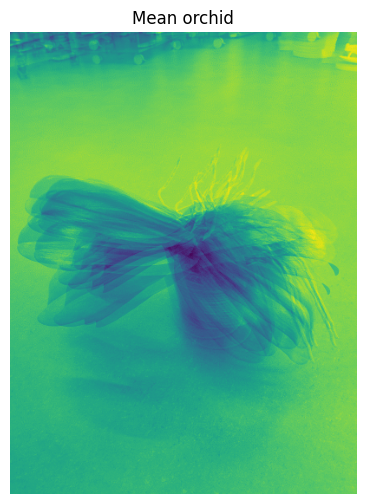

In [4]:
in_dir = './dec2021/ImagePCA/'
all_fish = ["discus.jpg", "guppy.jpg", "kribensis.jpg", "neon.jpg", "oscar.jpg", "platy.jpg",
"rummy.jpg", "scalare.jpg", "tiger.jpg", "zebra.jpg"]

files = glob.glob(f"{in_dir}/*.png")
height, width, channels= io.imread(files[0]).shape
data_matrix = np.zeros((len(files)-1, height * width))
for i, f in enumerate(files):
    if i == 6: # do not count last picture
        break
    im = io.imread(f)
    f_g = color.rgb2gray(im)
    data_matrix[i, :] = f_g.flatten()
average_orchid = np.mean(data_matrix, axis=0)

average_orchid_img = create_u_byte_image_from_vector(average_orchid, height, width, 1)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.imshow(average_orchid_img)
ax.set_title("Mean orchid")
ax.set_axis_off()
plt.show()

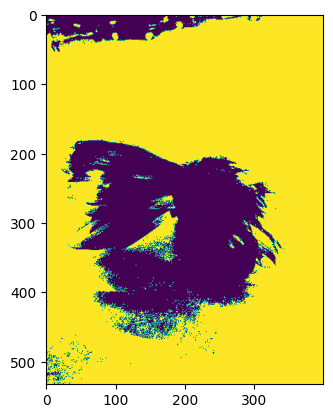

In [5]:
bin_im = average_orchid_img > 150

plt.imshow(bin_im)
ax.set_title("gray orchid")
ax.set_axis_off()
plt.show()

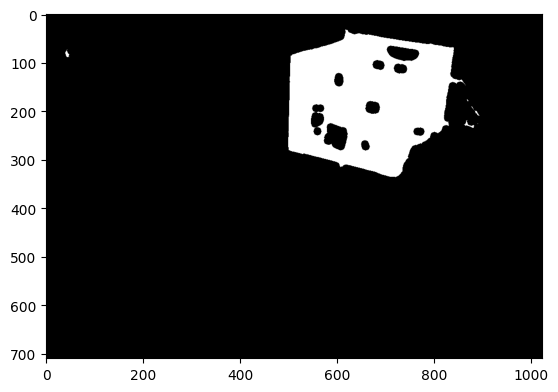

In [6]:
#bike
bikes = io.imread('./dec2021/BikeImage/bikes.png')
bin_im = (bikes[:,:,0] < 100) & (bikes[:,:,1] > 200) & (bikes[:,:,2]>100)

footprint = disk(8)
closed = binary_closing(bin_im, footprint)
plt.imshow(closed, cmap = 'gray')
plt.show()

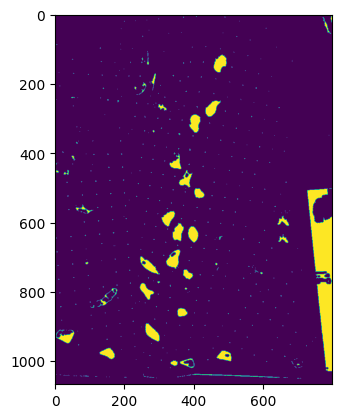

Number of labels: 566


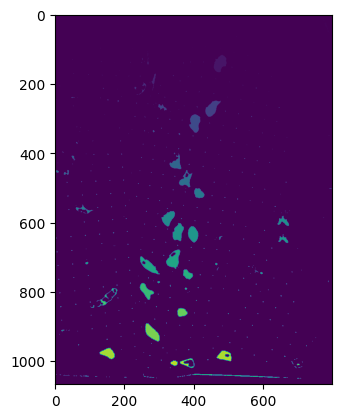

In [7]:
wall = io.imread('./dec2021/Climbing/ClimbingWall.png')
bin_wall = (wall[:,:,0] < 60) & (wall[:,:,1] <  200) & (wall[:,:,2]<100)

footprint = disk(3)
closed_wall = binary_closing(bin_wall, footprint)
plt.imshow(closed_wall)
plt.show()

closed_wall = segmentation.clear_border(closed_wall) #remove all border blobsi
label_img = measure.label(closed_wall, connectivity=2)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")# == number of blobs

plt.imshow(label_img)
plt.show()


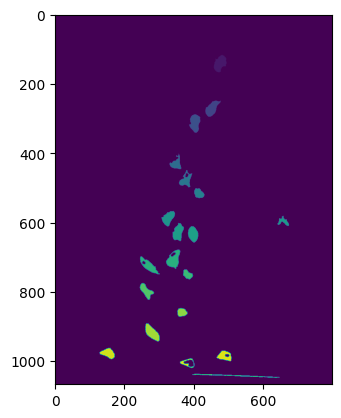

20

In [8]:
region_props = measure.regionprops(label_img)

max_area = 300
max_perim = 500

label_img_filter = label_img.copy()
for region in region_props:
    area = region.area
    perimeter = region.perimeter
    if area < max_area or perimeter > max_perim:
        for coord in region.coords:
            label_img_filter[coord[0], coord[1]] = 0


plt.imshow(label_img_filter)
plt.show()

label_img = measure.label(label_img_filter, connectivity=2)
n_labels = label_img.max()
n_labels

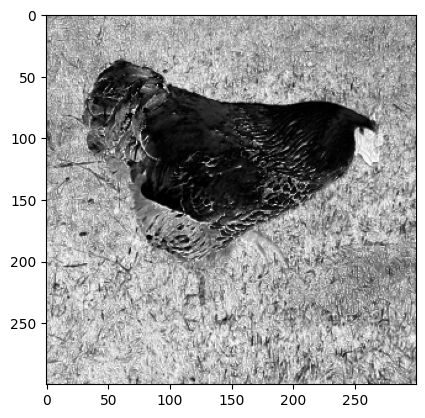

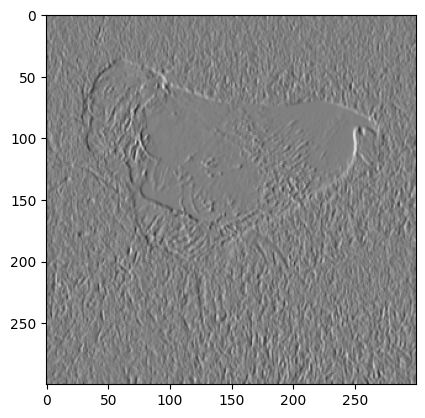

In [9]:
bird = io.imread('./dec2021/Bird/bird.png')
bird_hsv = color.rgb2hsv(bird)
bird_s = bird_hsv[:,:,1]
im_edges = prewitt_v(bird_s) #border replication

plt.imshow(bird_s, cmap = 'gray')
plt.show()

plt.imshow(im_edges, cmap="gray", vmin=-1, vmax=1)
plt.show()

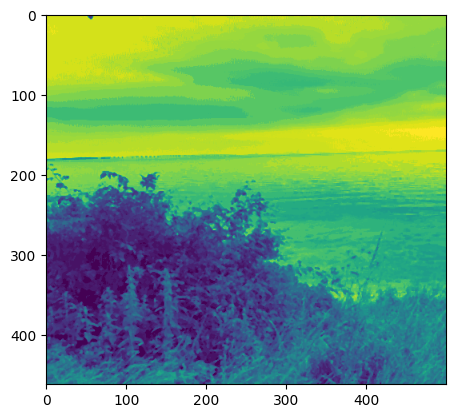

In [10]:
water = io.imread('./dec2021/Water/water_gray.png')
water = color.rgb2gray(water)
size = 3
footprint = np.ones([size, size]) #3x3 median filter
med_img = median(water, footprint)

plt.imshow(med_img)

In [11]:

def histogram_stretching(image, min_val, max_val):
    # Normalizza l'immagine tra 0 e 1
    # normalized_image = exposure.rescale_intensity(
    #     image, in_range="image", out_range=(0, 1)
    # )

    # Esegui l'istogramma stretching usando i valori minimi e massimi desiderati
    stretched_image = exposure.rescale_intensity(image, in_range=(min_val, max_val))

    return stretched_image

water = io.imread('./dec2021/Water/water_gray.png')
print(water.shape)
size = 3
footprint = np.ones([size, size, size]) #3x3 median filter
med_img = median(water, footprint)
im_out = histogram_stretching(water, 12,230)
im_out[19][19]

(462, 500, 3)


array([223, 223, 223], dtype=uint8)

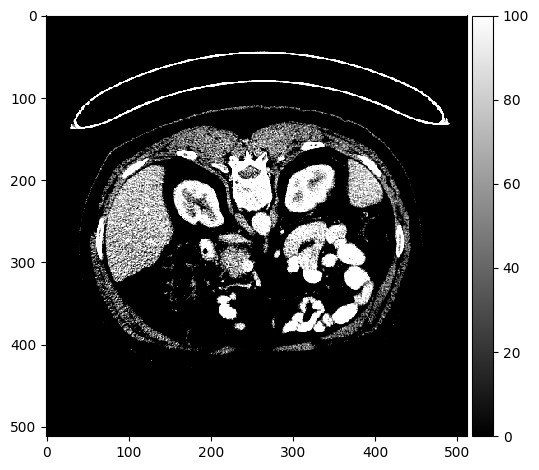

124.72452830188679 73.28221208665906 838.4418604651163


array([ 99.00337019, 481.58319438])

In [12]:
ct = dicom.read_file('./dec2021/DICOM/1-131.dcm') #single dicom slice w/ annotations
img = ct.pixel_array #extract pixel data, already hounsfield units -> its the format for dicom images
io.imshow(img, vmin=0, vmax=100, cmap='gray')
io.show()

roi_liver = io.imread('./dec2021/DICOM/LiverROI.png')
liver_mask = roi_liver > 0 #white values
liver_values = img[liver_mask] #spleen values contain the HU values (HU values are the pixel value for DICOM images, )
mu_liver = np.mean(liver_values)
std_liver = np.std(liver_values)

roi_spleen = io.imread('./dec2021/DICOM/SpleenROI.png')
spleen_mask = roi_spleen > 0 #white values
spleen_values = img[spleen_mask] #spleen values contain the HU values (HU values are the pixel value for DICOM images, )
mu_spleen = np.mean(spleen_values)
std_spleen = np.std(spleen_values)

roi_bone = io.imread('./dec2021/DICOM/BoneROI.png')
bone_mask = roi_bone > 0 #white values
bone_values = img[bone_mask] #spleen values contain the HU values (HU values are the pixel value for DICOM images, )
mu_bone = np.mean(bone_values)
std_bone = np.std(bone_values)

print(mu_spleen,mu_liver, mu_bone)

rng = np.array([(mu_liver+mu_spleen)/2, (mu_spleen+mu_bone)/2])
rng

Number of labels: 17


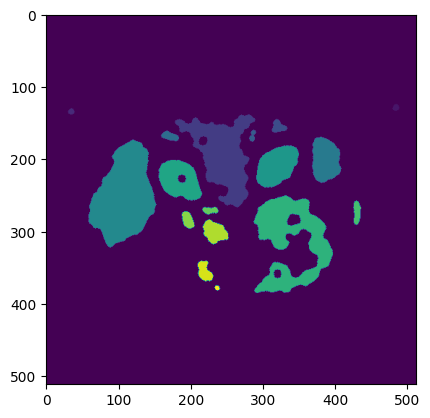

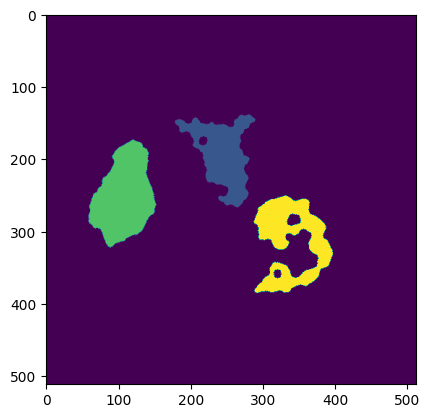

In [13]:
t1= 85
t2 = 400
img_bin = (img > t1) & (img < t2)
plt.imshow(img_bin)

footprint = disk(5)
closed = binary_closing(img_bin, footprint)
footprint = disk(3)
opened = binary_opening(closed, footprint)


label_img = measure.label(opened, connectivity=2)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")# == number of blobs

plt.imshow(label_img)
plt.show()
region_props = measure.regionprops(label_img)

max_area = 4000
min_area = 1000
label_img_filter = label_img.copy()
for region in region_props:
    area = region.area
    perimeter = region.perimeter
    if area < max_area or area < min_area:
        for coord in region.coords:
            label_img_filter[coord[0], coord[1]] = 0

plt.imshow(label_img_filter)
plt.show()

In [14]:
donald1 = io.imread('./dec2021/Donald/donald_1.png')
donald2 = io.imread('./dec2021/Donald/donald_2.png')

fixed_data = loadmat('./dec2021/Donald/donaldfixedPoints.mat')
moving_data = loadmat('./dec2021/Donald/donaldmovingPoints.mat')

print(moving_data)
fixed_landmarks = fixed_data['fixedPoints']
moving_landmarks = moving_data['movingPoints']

com_fixed = np.average(fixed_landmarks)
com_moving = np.average(moving_landmarks)

av1 = np.mean(fixed_landmarks, axis=0) #euclidian distance
av2 = np.mean(moving_landmarks, axis=0)

dist = np.linalg.norm(av2 - av1)
dist

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Nov 26 11:57:19 2021', '__version__': '1.0', '__globals__': [], 'movingPoints': array([[208.29742765,  66.81832797],
       [129.5192926 , 131.12700965],
       [ 45.11414791, 206.68971061],
       [265.37138264, 455.88585209],
       [352.18810289, 382.73472669],
       [441.41639871, 307.97588424]])}


6.4113001682773065

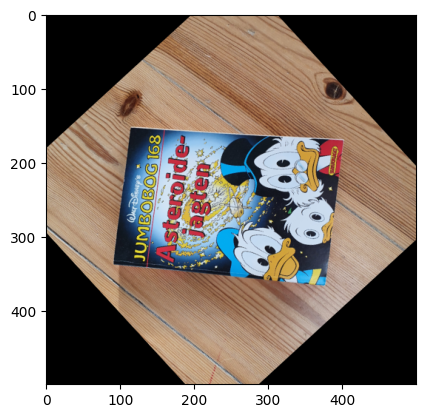

value on warped -> [210 227 244]


In [15]:
tform = SimilarityTransform()
tform.estimate(fixed_landmarks, moving_landmarks)
tform.scale_params = True
dst_transform = matrix_transform(moving_landmarks, tform.params) #similarity transform in numpy arr

warped_im = warp(donald2, tform.inverse)

plt.imshow(warped_im)
plt.show()

w_im  = img_as_ubyte(warped_im)
print(f"value on warped -> {w_im[299][299]}")

In [16]:
f = 15
area = 5.4 * 4.2 * 10**-3 #size of one pixel
measures = 5.4
b = f
im_size = 6480 * 5040
measures_camera = 6480
g = 1.5 # g = dist
diam = 2400#pixels

In [17]:
diam_in_mm_ccd = measures * diam
diam_in_mm_ccd

# B = dim_camera:measures=diam
B = measures * diam / measures_camera
G = g * B / b
G #in meters

0.2

0.9314763598050836

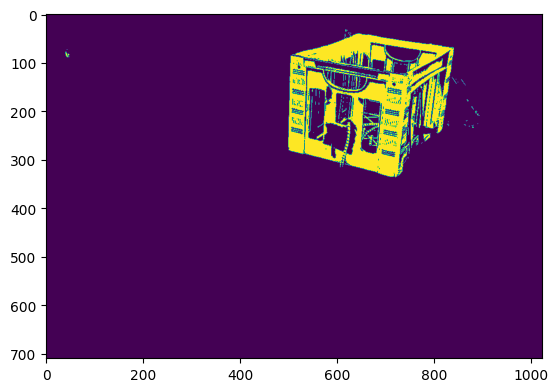

In [18]:
plt.imshow(bikes)
bikes_bin = (bikes[:,:,0] < 100) & (bikes[:,:,1] > 200) & (bikes[:,:,2] > 100)
plt.imshow(bikes_bin)

closed = binary_closing(bikes_bin, footprint = disk(8))

box_gt = io.imread('./dec2021/BikeImage/boxROI.png')
gt_bin = box_gt > 0
dice_score = 1 - distance.dice(closed.ravel(), gt_bin.ravel())
dice_score


In [19]:
'''Grass: 68, 65, 67
 Road: 70, 80, 75 
 Sky: 77, 92, 89
 '''
#minimum distance classifier
mu_grass = (68 + 65 + 67)/3
mu_road = (70 + 80 + 75)/3
mu_sky = (77 + 92 + 89)/3

print(mu_grass, mu_road, mu_sky)
(mu_grass + mu_road)/2 # == 71 -> so grass goes from 0 to 71

66.66666666666667 75.0 86.0


70.83333333333334

In [20]:
#parametric classifier
grass = [68, 65, 67]

road = [70, 80, 75]

sky =[77, 92, 89] 


a_list = [grass, sky, road]

def parametric_distance_classifier(lista):
    all_means, stds = [], []

    for el in lista:
        mu = round(np.mean(el), 3)
        std = round(np.std(el), 3)
        all_means.append(mu)
        stds.append(std)
        print(f"{el} - mean = {mu}     std = {std}")

    thresholds = []
    print(all_means)
    # Calcola la soglia di decisione tra classi adiacenti
    print(range)
    for idx in range(3 - 1):

        mu_low = all_means[idx]
        std_low = stds[idx]
        mu_high = all_means[idx + 1]
        std_high = stds[idx + 1]
        thres_low_high = None

        # Calcola la soglia tra le due distribuzioni normali
        for test_value in np.linspace(mu_low, mu_high, 1000):
            if norm.pdf(test_value, mu_high, std_high) > norm.pdf(test_value, mu_low, std_low):
                thres_low_high = round(test_value, 3)
                break

        # Memorizza la soglia tra classi adiacenti
        if thres_low_high is not None:
            thresholds.append((f"class_{idx + 1} and class_{idx + 2}", thres_low_high))

    result = sorted(thresholds, key=lambda x: x[1])
    print("\nThresholds between adjacent classes:")
    for threshold in result:
        print(f"{threshold[0]}: {threshold[1]}")
    return result


res = parametric_distance_classifier(a_list)

[68, 65, 67] - mean = 66.667     std = 1.247
[77, 92, 89] - mean = 86.0     std = 6.481
[70, 80, 75] - mean = 75.0     std = 4.082
[66.667, 86.0, 75.0]
<class 'range'>

Thresholds between adjacent classes:
class_1 and class_2: 70.441
class_2 and class_3: 80.307


In [23]:
def compute_optimal_path(grid):
    """
    Compute the optimal path in a grid of numbers.
    
    Parameters:
        grid (numpy.ndarray): 2D array representing the grid of numbers.
        
    Returns:
        list: List of tuples representing the coordinates of the optimal path.
    """
    # Initialize the memoization table to store minimum path sum
    memo = np.zeros_like(grid)
    memo[0] = grid[0]  # Copy the first row of the grid to memo
    
    # Iterate over each row of the grid
    for i in range(1, grid.shape[0]):
        # Update the memoization table based on the minimum path sum
        for j in range(grid.shape[1]):
            # Update memo[i, j] with the minimum of memo[i-1, j-1], memo[i-1, j], and memo[i-1, j+1]
            if j == 0:
                memo[i, j] = grid[i, j] + min(memo[i-1, j], memo[i-1, j+1])
            elif j == grid.shape[1] - 1:
                memo[i, j] = grid[i, j] + min(memo[i-1, j-1], memo[i-1, j])
            else:
                memo[i, j] = grid[i, j] + min(memo[i-1, j-1], memo[i-1, j], memo[i-1, j+1])
    
    # Find the minimum value in the last row of the memoization table
    min_value = np.min(memo[-1])
    
    # Backtrack to find the optimal path
    optimal_path = []
    j = np.argmin(memo[-1])  # Start from the column index with the minimum value in the last row
    for i in range(grid.shape[0] - 1, -1, -1):
        optimal_path.append((i, j))
        # Find the previous column index based on the adjacent cells
        if j == 0:
            j = np.argmin([memo[i-1, j], memo[i-1, j+1]])
        elif j == grid.shape[1] - 1:
            j = np.argmin([memo[i-1, j-1], memo[i-1, j]])
        else:
            j = np.argmin([memo[i-1, j-1], memo[i-1, j], memo[i-1, j+1]]) - 1 + j
        
    return optimal_path[::-1]  # Reverse the path to start from the top-left corner



In [24]:
grid = np.array([[208, 71, 244, 202, 173, 180],
                 [231, 139, 124, 245, 193, 8],
                 [32, 244, 204, 167, 189, 71],
                 [233, 246, 36, 9,100,12],
                 [161, 40, 108, 217, 167, 25],
                 [25, 248, 234, 238, 44, 210]
                 ])

path = compute_optimal_path(grid)
path

[(0, 1), (1, 1), (2, 0), (3, 1), (4, 5), (5, 4)]